# Part 1

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy
import random

-different value distributions d
-different numbers of bidders in each auction (e.g., do the results change between the case of two bidders in the auction and five or ten bidders in the auction?) 
-different number of items for sale in each round (selling 4 items with the truthful 5th price auction)

## Generation Methods

In [13]:
def generate_random_bidlist(num_bidders, num_rounds):
    bid_list = []
    for i in range(num_rounds):
        bidder_bids = [random.random() for i in range(num_bidders)]
        bid_list.append(bidder_bids)
    return bid_list

def generate_quadratic_bidlist(num_bidders, num_rounds):
    bid_list = []
    for i in range(num_rounds):
        bidder_bids = [math.sqrt(random.random()) for i in range(num_bidders)]
        bid_list.append(bidder_bids)
    return bid_list

def generate_exponential_bids(num_bidders, num_rounds):
    bids_uncapped = numpy.random.exponential(scale=1.0, size=num_bidders)
    for index in range(num_bidders):
        if bids_uncapped[index] > 10:
            bids_uncapped[index] = 10
    return bids_uncapped.tolist()

def generate_exponential_bidlist(num_bidders, num_rounds):
    return [generate_exponential_bids(num_bidders, num_rounds) for i in range(num_rounds)]

def generate_linear_discretization(val, epsilon):
    action_list = []
    k = val / epsilon
    
    #calculate number of incremented bids
    num_integ = math.ceil(k)
    
    #value of each linear increment 
    increm = k / num_integ
    
    bid = val
    j = 0
    while bid >= 0:
        action_list.append(bid)
        j = j + 1
        bid = val - (epsilon * (increm * j))
    return action_list

# this doesn't work yet, still trying to figure it out
def generate_geometric_discretization(val, epsilon):
    action_list = []
    k = 1/math.e * numpy.log(val)
    bid = val
    j = 0
    while bid >= 0:
        if j == 0: 
            #add both the value bid and the bid of value - 1 according to formula
            action_list.append(bid)
            action_list.append(val - pow((1 + epsilon), j))
        else: 
            if bid not in action_list: 
                action_list.append(bid)
                bid = val - pow((1 + epsilon), j)
            else:
                bid = val - pow((1 + epsilon), j)
        j = j + 1
        
    #add a bid of 0 if not already done so
    if 0 not in action_list:
        action_list.append(0)
        
    return action_list

print(generate_linear_discretization(1, .05))

print(generate_geometric_discretization(1, 0.05))

[1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6499999999999999, 0.6, 0.55, 0.5, 0.44999999999999996, 0.3999999999999999, 0.35, 0.29999999999999993, 0.25, 0.19999999999999996, 0.1499999999999999, 0.09999999999999998, 0.04999999999999993, 0.0]
[1, 0.0]
[[0.9055232152418847, 1.6834901469706134, 1.7386869156822915], [0.031082406184490298, 0.21361187212332117, 0.517336235013373], [2.3850820475106587, 6.370841645927683, 1.6143137279667343]]


## Algorithm Classes

In [4]:
class ExponentialWeights:
    
    def __init__(self, epsilon, num_actions=2):
        self.weights_vector = [1 for i in range(num_actions)]
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.actions_list = [i for i in range(num_actions)]
        self.epsilon = epsilon
        self.num_actions = num_actions
        
    def reset_instance(self, num_actions=2):
        self.weights_vector = [1 for i in range(num_actions)]
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.actions_list = [i for i in range(num_actions)]
        self.num_actions = num_actions

    
    def choose_action(self, max_payoff):
        # find weights
        current_weights = [None for i in range(self.num_actions)]
        for action in range(self.num_actions):
            if self.totals_by_round == []:
                V_last = 0
            else:
                V_last = self.totals_by_round[-1][action]
            exp = V_last / max_payoff
            current_weights[action] = pow(1 + self.epsilon, exp)
        # randomly select from actions using weights as probabilities
        selected_action = random.choices(self.actions_list, weights=current_weights, k=1)[0]
        self.choices_by_round.append(selected_action)
        self.weights_vector.append(current_weights)
        #print('current weights', current_weights)
        return selected_action
    
    def process_payoff(self, selected_payoff, payoff_list):
        # add new payoffs to totals, add payoff choice this round to payoffs matrix
        self.payoffs_by_round.append(selected_payoff)
        if self.totals_by_round == []: 
            self.totals_by_round.append([payoff_list[i] for i in range(self.num_actions)])
        else:
            last_round_totals = self.totals_by_round[-1]
            self.totals_by_round.append([last_round_totals[i] + payoff_list[i] for i in range(self.num_actions)])
                
            
    #NOTE: totals_by_round[-1] at the end of the simulation will help find 'OPT'

In [5]:
class AuctionCentricEW:
    
    def __init__(self, epsilon, num_actions=2):
        self.weights_vector = [1 for i in range(num_actions)]
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.never_no_payoff = [True for i in range(num_actions)]
        self.actions_list = [i for i in range(num_actions)]
        self.epsilon = epsilon
        self.num_actions = num_actions
        
    def reset_instance(self, num_actions=2):
        self.weights_vector = [1 for i in range(num_actions)]
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.never_no_payoff = [True for i in range(num_actions)]
        self.actions_list = [i for i in range(num_actions)]
        self.num_actions = num_actions

    
    def choose_action(self, max_payoff):
        # find weights
        current_weights = [None for i in range(self.num_actions)]
        for action in range(self.num_actions):
            if self.totals_by_round == []:
                V_last = 0
            else:
                V_last = self.totals_by_round[-1][action]
            exp = V_last / max_payoff
            current_weights[action] = pow(1 + self.epsilon, exp)
        # randomly select from actions using weights as probabilities
        selected_action = random.choices(self.actions_list, weights=current_weights, k=1)[0]
        
        # if selected action has never been 0, instead pick highest weight 'never_no_payoff'
        if self.never_no_payoff[selected_action]:
            max_weight = current_weights[selected_action]
            max_action = selected_action
            for action in range(self.num_actions):
                if self.never_no_payoff[action] and current_weights[action] > max_weight:
                    max_weight = current_weights[action]
                    max_action = action
            selected_action = max_action
        
        self.choices_by_round.append(selected_action)
        self.weights_vector.append(current_weights)
        #print('current weights', current_weights)
        return selected_action
    
    def process_payoff(self, selected_payoff, payoff_list):
        # add new payoffs to totals, track payoff this round
        self.payoffs_by_round.append(selected_payoff)
        if self.totals_by_round == []: 
            self.totals_by_round.append([payoff_list[i] for i in range(self.num_actions)])
        else:
            last_round_totals = self.totals_by_round[-1]
            self.totals_by_round.append([last_round_totals[i] + payoff_list[i] for i in range(self.num_actions)])
            
        # update never_been_zero actions
        for index in range(len(payoff_list)):
            payoff = payoff_list[index]
            if payoff == 0 and self.never_no_payoff[index]:
                self.never_no_payoff[index] = False

In [6]:
class FTL:
    
    def __init__(self, num_actions=2):
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.actions_list = [i for i in range(num_actions)]
        self.num_actions = num_actions
        
    def reset_instance(self, num_actions=2):
        self.totals_by_round = []
        self.payoffs_by_round = []
        self.choices_by_round = []
        self.actions_list = [i for i in range(num_actions)]
        self.num_actions = num_actions
    
    def choose_action(self, max_payoff):
        # randomly select from actions using highest total payoff so far
        if self.totals_by_round != []:
            selected_action = self.totals_by_round[-1].index(max(self.totals_by_round[-1]))
            self.choices_by_round.append(selected_action)
            return selected_action
        else:
            selected_action = random.randrange(0, self.num_actions)
            return selected_action
    
    def process_payoff(self, selected_payoff, payoff_list):
        # add new payoffs to totals, add payoff choice this round to payoffs matrix
        self.payoffs_by_round.append(selected_payoff)
        if self.totals_by_round == []: 
            self.totals_by_round.append([payoff_list[i] for i in range(self.num_actions)])
        else:
            last_round_totals = self.totals_by_round[-1]
            self.totals_by_round.append([last_round_totals[i] + payoff_list[i] for i in range(self.num_actions)])
                
            
    #NOTE: totals_by_round[-1] at the end of the simulation will help find 'OPT'

## Auction Simulator

In [7]:
# helpers to find regret of an algorithm
def sum_to_round_i(alg_payoffs, current_round):
    total = 0
    for i in range(current_round):
        total += alg_payoffs[i]
    return total

def individual_regrets(alg_payoffs, round_totals):
    final_payoffs = round_totals[-1]
    opt_action = final_payoffs.index(max(final_payoffs))
    individual_regrets = [0 for i in range(len(alg_payoffs))]
    for round_x in range((len(alg_payoffs))):
        individual_regrets[round_x] = (round_totals[round_x][opt_action] - sum_to_round_i(alg_payoffs, round_x)) / (round_x + 1)
    return individual_regrets

def find_payoff(r_price, bid_list, num_items=None):
    if num_items == None:
        sorted_bids = sorted(bid_list, reverse=True)
        max_bid = sorted_bids[0]
        second_bid = sorted_bids[1]
        if r_price > second_bid and r_price <= max_bid:
            return r_price
        elif r_price > second_bid and r_price > max_bid:
            return 0
        else:
            return second_bid
    else:
        sorted_bids = sorted(bid_list, reverse=True)
        first_bid = sorted_bids[num_items - 2]
        second_bid = sorted_bids[num_items - 1]
        if r_price > second_bid and r_price <= first_bid:
            return r_price
        elif r_price > second_bid and r_price > first_bid:
            return 0
        else:
            return second_bid

def auction_simulator(alg, bid_lists, num_rounds, max_bid, price_discretization, num_items=None):
    num_actions = len(price_discretization)
    for bid_list in bid_lists:
        # have the algorithm select a bid
        alg_action = alg.choose_action(max_bid)
        alg_price = price_discretization[alg_action]
        
        # calculate payoff list for each reserve price on the discretization
        payoff_list = []
        for reserve_price in price_discretization:
            payoff_list.append(find_payoff(reserve_price, bid_list, num_items))
        alg_payoff = payoff_list[alg_action]
        alg.process_payoff(alg_payoff, payoff_list)
    
    # calculate regrets and payoffs
    alg_regrets = individual_regrets(alg.payoffs_by_round, alg.totals_by_round)
    alg_payoffs = alg.payoffs_by_round
    
    return alg_regrets, alg_payoffs

#bid_lists = [[0, 1], [0, .75], [0, .5], [0, .25]]
#alg = ExponentialWeights(0.0, len(generate_linear_discretization(0, 1, 0.25)))
#alg_regrets, alg_payoffs = auction_simulator(alg, bid_lists, 4, 1, generate_linear_discretization(0, 1, 0.25))
#print(alg_regrets)
#print(alg_payoffs)
#print(alg.weights_vector[-1])
#print(alg.choices_by_round)
#print(alg.totals_by_round)

## Auction Monte Carlo Trials

In [8]:
## Auction Monte Carlo Trials
def auction_trial(alg, auction_list, num_rounds, max_bid, price_discretization, num_items=None):
    alg_avg_regret_per_round = None
    alg_avg_payoff_per_round = None

    for auction in auction_list:
        # find which trial number we are on
        n = auction_list.index(auction)
                    
        # run matchup and find regret lists
        new_alg_regrets, new_alg_payoffs = auction_simulator(alg, auction, num_rounds, max_bid, price_discretization, num_items)
        
        # update average regrets
        if alg_avg_regret_per_round == None:
            alg_avg_regret_per_round = new_alg_regrets
        else:
            for i in range(len(alg_avg_regret_per_round)):
                alg_avg_regret_per_round[i] = ((n * alg_avg_regret_per_round[i]) + new_alg_regrets[i]) / (n + 1) 
        
        # update average payoffs
        if alg_avg_payoff_per_round == None:
            alg_avg_payoff_per_round = new_alg_payoffs
        else:
            for i in range(len(alg_avg_regret_per_round)):
                alg_avg_payoff_per_round[i] = ((n * alg_avg_payoff_per_round[i]) + new_alg_payoffs[i]) / (n + 1) 
        
        # reset alg internally stored values
        alg.reset_instance(num_actions=len(price_discretization))
        #print('final weights', alg.weights_vector)
    return alg_avg_regret_per_round, alg_avg_payoff_per_round

#bid_lists = [[0, 1], [0, .75], [0, .5], [0, .25]]
#alg = ExponentialWeights(1.0, len(generate_linear_discretization(0, 1, 0.25)))
#alg_regrets, alg_payoffs = auction_trial(alg, [bid_lists, bid_lists], 4, 1, generate_linear_discretization(0, 1, 0.25))
#print(alg_regrets)
#print(alg_payoffs)

## Visualization of Regrets

In [9]:
def visualize_rounds(alg_regrets, rounds, lr, plot_title, alg_name, trial_type, y_label):
    
    file_name = plot_title + '.png'
    
    x = numpy.array(list(range(0, rounds)))
    y_1 = numpy.array(alg_regrets)
    plt.plot(x, y_1, label='{alg_name}, learning rate = {lr}'.format(alg_name=alg_name, lr = lr), linewidth=1)
    plt.xlabel("Round")
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend(loc='best', prop={'size': 7})
    
    plt.savefig(file_name)

    plt.show()


# Trials on Different Bidder Generation Methods, Discretizations, Number of Bidders

0.01299069577378768
0.41616988612585476
avg 1 0.40823840872255757


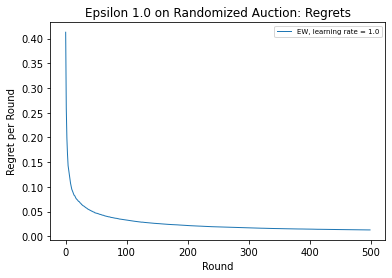

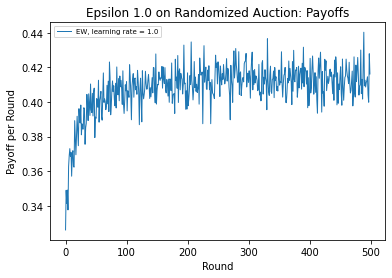

0.012565918793102994
0.40688222060667073
avg 1 0.4091811145078973


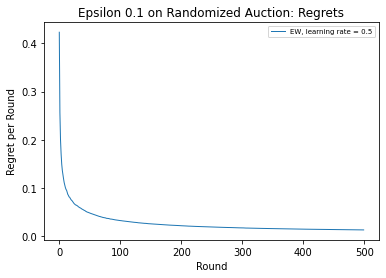

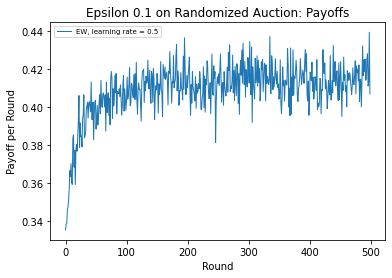

0.012835861827543952
0.42901871154944515
avg 1 0.4081012410890721


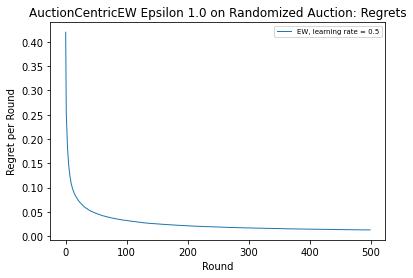

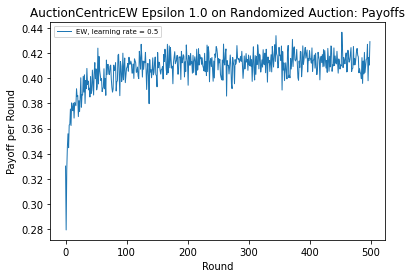

0.009456580934403803
0.40134178228815076
avg 2 0.4115053021151272


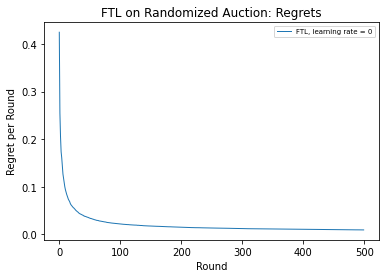

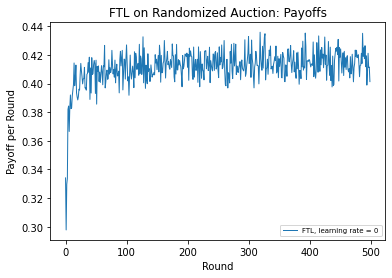

0.08914690060214778
0.31136484773286627
avg 2 0.3318521401377341


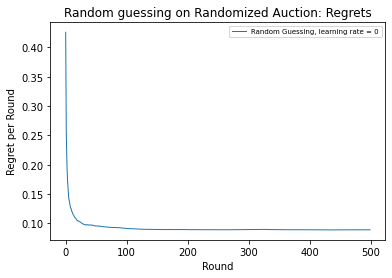

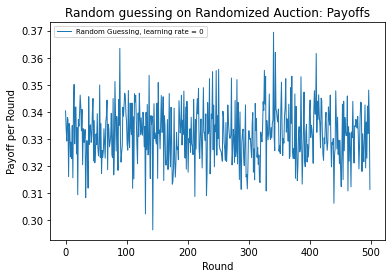

In [10]:
# PARAMETERS
NUM_TRIALS = 1000
NUM_ROUNDS = 500

# 2 bidder random values auction trial Epsilon = 1
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder random values auction trial with Epsilon = 0
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, .5, "Epsilon 0.1 on Randomized Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, .5, "Epsilon 0.1 on Randomized Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder random values auction trial Epsilon = 1, AuctionCentricEW
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = AuctionCentricEW(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, .5, "AuctionCentricEW Epsilon 1.0 on Randomized Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, .5, "AuctionCentricEW Epsilon 1.0 on Randomized Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder random values auction trial Epsilon = infinity
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = FTL(len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 2', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 0, "FTL on Randomized Auction: Regrets", "FTL", "FTL on Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 0, "FTL on Randomized Auction: Payoffs", "FTL", "FTL on Randomized Auction", "Payoff per Round")


# 2 bidder random values auction trial Epsilon = 0
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 2', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 0, "Random guessing on Randomized Auction: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 0, "Random guessing on Randomized Auction: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")


### Trials with different numbers of bidders

0.012152168473313539
0.5280503665455801
avg 1 0.5233151235741376


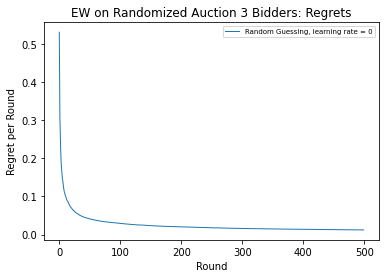

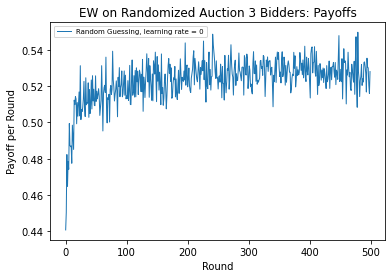

0.008785817943588278
0.6725582810492686
avg 1 0.6672317241926311


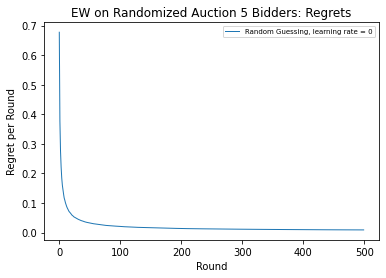

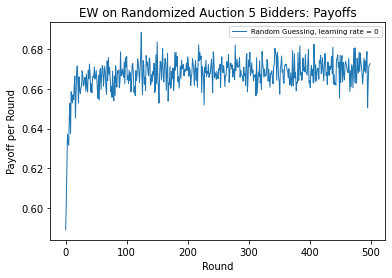

0.003313500615466834
0.9021302898884764
avg 1 0.9037801679144333


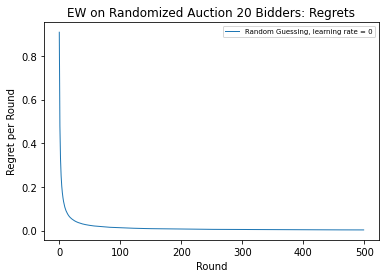

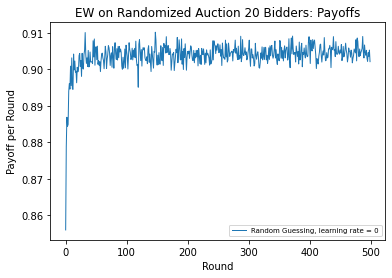

In [ ]:
# 3 bidders EW on random values

num_bidders = 3
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 0, "EW on Randomized Auction 3 Bidders: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 0, "EW on Randomized Auction 3 Bidders: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")


num_bidders = 5
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")

num_bidders = 20
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 0, "EW on Randomized Auction 20 Bidders: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 0, "EW on Randomized Auction 20 Bidders: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")


num_bidders = 20
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 0, "AuctionCentricEW on Randomized Auction 20 Bidders: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 0, "AuctinoCentricEW on Randomized Auction 20 Bidders: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")


### Trials with different numbers of auctioned items

In [ ]:
num_bidders = 5
num_items = 4
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization, num_items)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders 4 Items: Regrets", "Random Guessing", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 0, "EW on Randomized Auction 5 Bidders 4 Items: Payoffs", "Random Guessing", "Randomized Auction", "Payoff per Round")


### Trials on different distributions

0.012630156700443375
0.4305313262355742
avg 1 0.40919405321999214


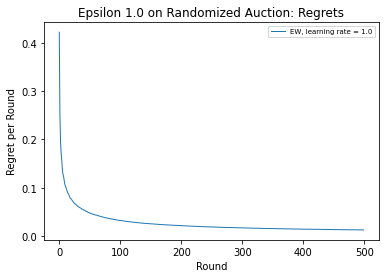

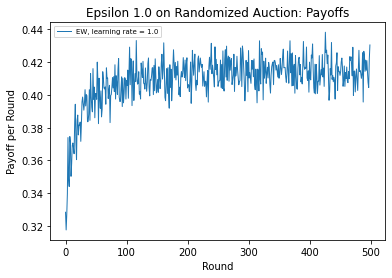

0.012812857234073211
0.5911766051004271
avg 1 0.5765241897717516


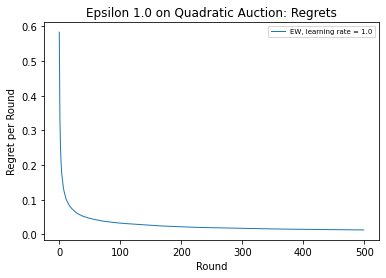

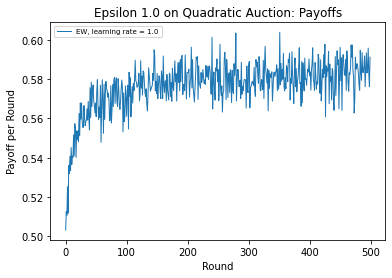

In [ ]:
# 2 bidder random values auction trial Epsilon = 1
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_random_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Randomized Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder quadratic values auction trial Epsilon = 1
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_quadratic_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Quadratic Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Quadratic Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")

# 2 bidder exponential values auction trial Epsilon = 1
num_bidders = 2
auction_list = []
min_payoff, max_payoff = 0, 1
# perform 500 trials each with 500 rounds and 2 bidders
for i in range(NUM_TRIALS):
    auction_list.append(generate_exponential_bidlist(num_bidders, NUM_ROUNDS))
price_discretization = generate_linear_discretization(1, 0.01)
alg = ExponentialWeights(1.0, len(price_discretization))
alg_regrets, alg_payoffs = auction_trial(alg, auction_list, NUM_ROUNDS, max_payoff, price_discretization)
print(alg_regrets[-1])
print(alg_payoffs[-1])
print('avg 1', sum(alg_payoffs) / len(alg_payoffs))
visualize_rounds(alg_regrets, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Exponential Auction: Regrets", "EW", "Randomized Auction", "Regret per Round")
visualize_rounds(alg_payoffs, NUM_ROUNDS, 1.0, "Epsilon 1.0 on Exponential Auction: Payoffs", "EW", "Randomized Auction", "Payoff per Round")





# Part 2

### Generating Meet Values